In [1]:
import sys

import numpy as np
import numpy.linalg as la
from qiskit import quantum_info as qi 

import matplotlib.pyplot as plt
import math
from scipy.linalg import sqrtm 
from scipy import linalg as sc_la

# http://cvxr.com/cvx/
import cvxpy as cp
import numpy as np

from joblib import Parallel, delayed
import time

from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit

# Useful functions

In [20]:
def is_pos_semidef(x):
    precission = 10**-4
    l=la.eigvalsh(x)
    return np.all(l >= -precission*la.norm(l,1)/len(l))
    #return np.all(la.eigvals(x) >= 0)


def randn_mat(n,k):
    return (np.random.randn(n,k) + 1j*np.random.randn(n,k))/math.sqrt(2.0) 

### Not needed ###
def rand_haar_U(n):
    # A Random U(n) matrix distributed with Haar measure
    # https://arxiv.org/abs/math-ph/0609050
    z = randn_mat(n,n)
    q,r = la.qr(z)
    d = np.diagonal(r)
    ph = d/np.abs(d)
    q = q*ph

    return q

### Not needed ###
def basis(n,i):
    b = np.zeros(n)
    b[i] = 1
    
    return b

def rand_haar_ket(n):
    psi=np.random.randn(n)+1j*np.random.randn(n)
    return psi/la.norm(psi)
    #return rand_haar_U(n)@basis(n,0)

def rand_haar_state(n):
    ket = rand_haar_ket(n)
    return np.outer(ket,np.conj(ket).T)

def randh_state_ensbl(d,n):
    ensbl = []
    for i in range(n):
        ensbl.append(rand_haar_state(d))
        
    return ensbl

#def rand_pauli_ket(n):
    
#    pauli = [[0,1],[1,0],
#             [math.sqrt(2.0)/2,math.sqrt(2.0)/2],[math.sqrt(2.0)/2,-math.sqrt(2.0)/2],
#             [math.sqrt(2.0)/2,1j*math.sqrt(2.0)/2],[math.sqrt(2.0)/2,-1j*math.sqrt(2.0)/2]]
#    if (n>1):
#    psi=np.random.randn(n)+1j*np.random.randn(n)
#    return psi/la.norm(psi)       

#def rand_1design_state_ensbl(d,n):
#    ensbl = []
#    for i in range(n):
#        ensbl.append(rand_haar_state(d))
#        
#    return ensbl

def rand_POVM(k,d,r):
    # PRXQuantum.1.020307
    POVM = []
    M = []
    S = np.zeros((d,d))*1j
    
    for i in range(k):
        A = randn_mat(d,r)
        B = A@np.conj(A).T
        M.append(B)
        S += B
    
    for i in range(k):
        S_inv = sqrtm(la.inv(S))
        POVM.append( S_inv@M[i]@S_inv )
        
    return POVM

def POVM_stats(rho,POVM,n):
    rng = np.random.default_rng()
    p = []
    for i in range(len(POVM)):
        p.append( np.trace(rho@POVM[i]).real )
    
    return rng.multinomial(n,p)

def POVM_ensbl_stats(ensbl,POVM,n):
    ens_stats = []
    for i in range(len(ensbl)):
        ens_stats.append(POVM_stats(ensbl[i],POVM,n))
        
    return ens_stats

def CJ_op(POVM):
    d = len(POVM[0])
    E = np.zeros((d**2,d**2))*1j
    for k in range(len(POVM)):
        for i in range(d):
            for j in range(d):
                rho_ij = np.outer(basis(d,i),basis(d,j))
                E += np.kron(sqrtm(POVM[k]) @ rho_ij @ np.conj(sqrtm(POVM[k])).T , rho_ij)
                
    return E/d

def Fidelity(E,F):
    E_sqrt = sqrtm(E)
    
    return np.trace(sqrtm(E_sqrt @ F @ E_sqrt))**2

def PLS(M,ensbl,n_samp,norm=2): # SDP solution
    v = np.asarray(POVM_ensbl_stats(ensbl,M,n_samp))/n_samp
    d = len(M[0])
    X = []
    for i in range(len(M)):
        X += [cp.Variable((d,d), hermitian=True) ]


    cost = []
    for i in range(len(ensbl)):
        for j in range(len(M)):
            cost+=[ cp.real( cp.trace(ensbl[i] @ X[j]) - v[i][j] ) ]

    expr = cp.sum_squares(cp.vstack(cost))

    constraints = [ cp.sum(X) - np.identity(d) == np.zeros((d,d)) ]
    constraints += [cp.atoms.norm_nuc.normNuc(X[i]) <= cp.trace(X[i]) for i in range(len(M))]

    prob = cp.Problem(cp.Minimize(expr), constraints)
    prob.solve()

    POVM_PLS = []
    for i in range(len(M)):
        POVM_PLS.append(X[i].value)
        
    cost_min = prob.value
    
    cond_check = [np.trace(cp.sum(X).value) - d < 10**-9]
    
    for i in range(len(M)):
        cond_check += [is_pos_semidef(X[i].value)]
        #np.linalg.eigvalsh(X[i].value)
        
    cond_violation = [constraints[0].violation()]
    for i in range(len(constraints)-1):
        cond_violation += [constraints[i+1].violation()/2]
        
    return POVM_PLS, cost_min, cond_check, cond_violation

def CVX_PLS(P):
    dout=len(P)
    din=len(P[0])
    Px=[cp.Variable((din,din),hermitian=True)  for i in range(dout)]
    constraints=[Pi>>0 for Pi in Px]+[sum(Pi for Pi in Px)==np.eye(din)]
    cf=cp.Minimize( sum((cp.norm(Px[i]-P[i],2)**2 for i in range(dout))))
    prob=cp.Problem(cf,constraints)
    prob.solve()
    return prob.value,[Pi.value for Pi in Px]    


def OS_POVM_Estimator(M,ensbl):
    # One-Shot estimator
    
    k = len(M)
    d = len(M[0])
    n_samp = len(ensbl)
    
    POVM_OneShot = []
    for i in range(k):
        POVM_OneShot.append(np.zeros((d,d))+np.zeros((d,d))*1j)

    for i in range(n_samp):
        measrmt = POVM_stats(ensbl[i],M,1)
        out = int(np.where(measrmt==1)[0])
        POVM_OneShot[out] += d*((d+1)*ensbl[i]-np.eye(d))
    
    return [X*(1/n_samp) for X in POVM_OneShot]

def operator_distance(M,N):
    k = len(M)
    d = len(M[0])
    
    dif = [X - Y for X, Y in zip(M,N)]
    op_norm = np.max( [sc_la.norm(Z,np.inf) for Z in dif] )

    return op_norm

def Block_Choi(M):
    k = len(M)
    d = len(M[0])
    choi = np.zeros((d*k,d*k)) + 1j*np.zeros((d*k,d*k))
    
    for i in range(k):
        choi += np.kron(np.outer(basis(k,i),np.conj(basis(k,i)).T),M[i])

    return choi

# Qiskit Implementation DIAMOND-NORM
def diamond_distance_Q(M,N):
    k = len(M)
    d = len(M[0])
    choi = np.zeros((d*k,d*k)) + 1j*np.zeros((d*k,d*k))
    
    for i in range(k):
        choi += np.kron(np.outer(basis(k,i),np.conj(basis(k,i)).T),M[i]-N[i])

    return qi.diamond_norm(qi.Choi(choi,input_dims=d,output_dims=k))    

# CVX Implementation DIAMOND-NORM
def diamond_distance(M,N):
    d2 = len(M)
    d1 = len(M[0])
    n = d1*d2
    
    J = 1j*np.zeros((n,n))
    for i in range(d2):
        J += np.kron(np.outer(basis(d2,i),np.conj(basis(d2,i)).T),M[i]-N[i])
    
    Y1 = cp.Variable((n,n),hermitian=True)
    Y0 = cp.Variable((n,n),hermitian=True)
    M1 = cp.hstack([Y0,-J])
    M2 = cp.hstack([-J.T.conj(),Y1])
    M = cp.vstack([M1,M2])
    
    constraints = [M>>0]
    
    cf = cp.Minimize( 0.5*(cp.norm(cp.partial_trace(Y0,[d1,d2],axis=1))+cp.norm(cp.partial_trace(Y1,[d1,d2],axis=1))))
    prob = cp.Problem(cf,constraints)
    prob.solve()
    
    return prob.value

def diamond_norm(J,d1,d2):
    n = d1*d2
    
    Y1 = cp.Variable((n,n),hermitian=True)
    Y0 = cp.Variable((n,n),hermitian=True)
    M1 = cp.hstack([Y0,-J])
    M2 = cp.hstack([-J.T.conj(),Y1])
    M = cp.vstack([M1,M2])
    
    constraints = [M>>0]
    
    cf = cp.Minimize( 0.5*(cp.norm(cp.partial_trace(Y0,[d1,d2],axis=1))+cp.norm(cp.partial_trace(Y1,[d1,d2],axis=1))))
    prob = cp.Problem(cf,constraints)
    prob.solve()
    
    return prob.value

def POVM_Affine_P(POVM_E):
    # Systematic error ~e-27
    k = len(POVM_E)
    d = len(POVM_E[0])
    
    # Reformulate as vector problem (MAt(d²)^k -> vec(k*d²))
    M_re = np.reshape(POVM_E,(d*k,d))
    M_re = np.reshape(M_re,(1,d**2*k)).T
    
    # Linear operator describing sum of measurement operators
    A = []
    for i in range(k):
        A.append(np.eye(d**2))
    
    A = np.reshape(A,(d**2*k,d**2)).T
    
    # Take pseudoinverse of A
    A_inv = la.pinv(A)

    # Affine offset for A(X+Y)=id => Y = A⁺id
    # reshaped to vector form
    Y = A_inv@(np.eye(d).reshape(d**2,1))
    
    ### Affine Projection ###
    
    # Compute Kernel of A
    # Columns of 'A_kern' are kernel vectors (d**2*k,dim(kern))    [Comp_Error of ~e-17]
    A_kern = sc_la.null_space(A)

    # Inner product of 'estimated POVM' minus 'affine Shift', with Kernel of A.
    Kern_P = A_kern.T@(M_re-Y)
    
    # Build Projected POVM onto the linear space 'AX=0' via linear combination of Kernel vectors.
    M_p = np.zeros((d**2*k,1))

    for i in range(len(Kern_P)):
        v_kern = A_kern.T[i].reshape(k*d**2,1)
        M_p = M_p + Kern_P[i]*v_kern

    # Final Affine projection by adding back the affine shift vector 'Y'.
    M_affine = M_p + Y

    # Reshape back to matrix form
    M_affine = np.reshape(M_affine,(d*k,d))
    M_affine = np.reshape(M_affine,(k,d,d))
    
    return M_affine

def PSD_P(E):
    # Systematic error ~e-16
    k = len(E)
    F = []
    for i in range(k):
        E_herm = (E[i] + np.conj(E[i]).T)/2
        e,V = la.eigh(E[i])
        H = V@np.diag(np.abs(e))@np.conj(V.T)
        E_res = (E_herm + H) / 2
        F.append((E_res + np.conj(E_res).T) / 2)

    return F

def randGuess(k,d):
    r_est = 0
    while (r_est*k < d):
        r_est = np.random.randint(1,d+1)
    
    return rand_POVM(k,d,r_est)


# CVX_PLS tests

In [61]:
d,r,k = [3,3,2]

res = np.zeros((10,3))
x = np.arange(10,110,10)

for n in x:
    for _ in range(10):
        n_samp = 100
        M = rand_POVM(k,d,r)
        ensbl = randh_state_ensbl(d,n_samp)
        
        M_LS = OS_POVM_Estimator(M,ensbl)
    
        _,M_2 = CVX_PLS(M_LS)
        _,M_1 = CVX_PLS(M_LS,1)
        _,M_inf = CVX_PLS(M_LS,"inf")
        
        M_est = [M_2, M_1, M_inf]
        
        for i in range(3):
            res[int(n/10-1)][i] += diamond_distance(M,M_est[i])

res = res/10

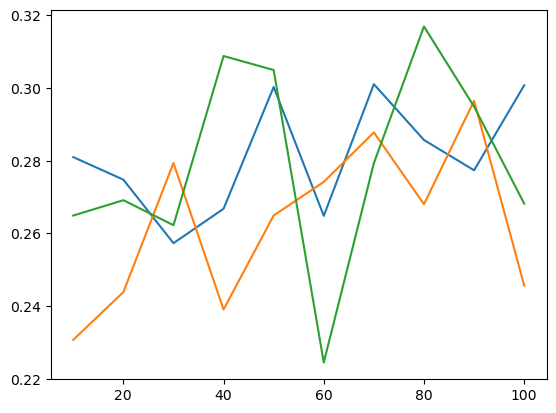

In [62]:
for i in range(3):
    plt.plot(x,res.T[i]*5)

# Tests

In [16]:
# Test of Op-norm approximation (Bernstein)
d,r,k = [3,3,2]
M = rand_POVM(k,d,r)
M = Block_Choi(M)

rho = rand_haar_state(d)
rho1 = np.kron(np.outer(basis(k,0),np.conj(basis(k,0)).T),d*((d+1)*rho - np.eye(d)))

A = np.zeros(3)

A[0] = sc_la.norm(rho1 - M,np.inf)
A[1] = sc_la.norm(d*((d+1)*rho - np.eye(d)),np.inf)
A[2] = sc_la.norm(2*d**2*rho,np.inf)

print(A)

[ 9.94547643 10.60293029 20.40439544]


In [58]:
# Test of Matrix Variance approximation (Bernstein)

d,r,k = [3,3,2]
M = rand_POVM(k,d,r)
Mtr = [np.trace(M[i])*np.eye(d) for i in range(k)]

M = Block_Choi(M)
Mtr = Block_Choi(Mtr)

dM = d*(d-1)*(M - Mtr)

A = np.zeros(3)

A[0] = sc_la.norm(dM,np.inf)
A[1] = sc_la.norm(d*(d-1)*(d+1)*M,np.inf)
A[2] = 3*d**3

print(A)

[ 9.48623545 28.35213391 81.        ]


In [13]:
d = 6  #effects' dimension
r = d   #effects' rank
k = 4   #number of effects
## Condition for valid POVMs r*k>=d

d,r,k = [3,3,2]
M = rand_POVM(k,d,r)
N = rand_POVM(k,d,r)

J = Block_Choi(M)

print(diamond_distance(M,[np.zeros((d,d)) for _ in range(k)]))
print(diamond_distance_Q(M,[np.zeros((d,d)) for _ in range(k)]))

print(diamond_norm(J,d,k))

print(diamond_distance_Q(M,N))

print(sc_la.norm(M[0]+M[1],'nuc'))

1.4217011581808017
1.4216885548790719
1.4217011581808017
0.9207692598634069
2.9999999999999947


# Diamon vs. Operator Inequality

In [3]:
#k,d,r = [3,3,3]

#res_Block = np.zeros(100)
#res_J = np.zeros(100)
#J_Block = rand_POVM(k,d,r)
#n = k*d
#J_Rand = np.random.randn(n,n)+1j*np.random.randn(n,n)
#J_Rand = (np.conj(J_Rand.T) + J_Rand)*.5
#J_Rand = J_Rand/np.matrix.trace(J_Rand)
    
    
def DiaVsOp(J,d,k):
    return [diamond_norm(J,d,k), la.norm(J,np.inf)]
    



In [4]:
x = np.arange(2,26,1)
median_error = np.zeros((2,len(x)))

for i in range(2,26,1):
    N = 100
    d,r,k = [i,5,5]
    
    J = Block_Choi(rand_POVM(k,d,r))
    
    t = time.time()
    results = Parallel(n_jobs=64)(delayed(DiaVsOp)(J,d,k) for _ in range(N))
    print("Time: {} | d = {}".format(time.time() - t, i))
    
    error = np.concatenate(results,axis=0).reshape((N,2)).T
    median_error[0][i-2] = np.median(error[0])
    median_error[1][i-2] = np.median(error[1])

    np.save("./QMT/runs_norm/drk_{}_{}_{}.npy".format(d,r,k),error)

Time: 1.362276554107666 | d = 2
Time: 0.5776913166046143 | d = 3
Time: 1.2913689613342285 | d = 4
Time: 1.9282665252685547 | d = 5
Time: 1.4201898574829102 | d = 6
Time: 4.569700479507446 | d = 7
Time: 2.618264675140381 | d = 8
Time: 5.717674732208252 | d = 9
Time: 11.106667280197144 | d = 10
Time: 17.810523986816406 | d = 11
Time: 27.26584553718567 | d = 12
Time: 22.356226444244385 | d = 13
Time: 20.210182905197144 | d = 14
Time: 44.24282240867615 | d = 15
Time: 273.6068959236145 | d = 16
Time: 44.77550959587097 | d = 17
Time: 565.2009918689728 | d = 18
Time: 408.08809328079224 | d = 19
Time: 47.02281141281128 | d = 20
Time: 104.56676054000854 | d = 21
Time: 88.57947397232056 | d = 22
Time: 105.57216238975525 | d = 23
Time: 116.3704628944397 | d = 24
Time: 603.3995263576508 | d = 25


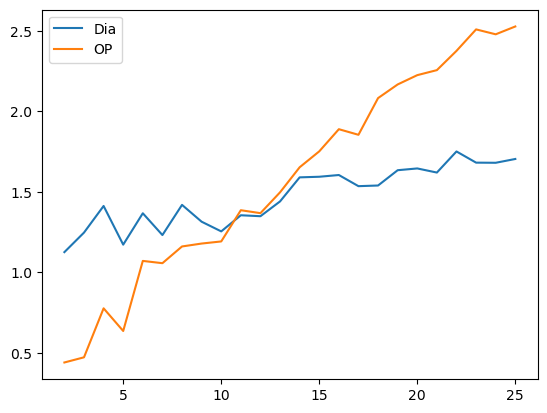

In [5]:
#x = np.arange(2,16,1)
#r,k = [5,10]

x = np.arange(2,26,1)
r,k = [5,5]

median_error = np.zeros((2,len(x)))
for i in range(2):
    for j in range(len(x)):
        median_error[i][j] = np.median(np.load("./QMT/runs_norm/drk_{}_{}_{}.npy".format(x[j],r,k))[i])
        
plt.plot(x,median_error[0],label='Dia')
plt.plot(x,median_error[1],label='OP')

plt.legend()

# One-Shot Estimator via Haar-Random States

In [10]:
d = 6  #effects' dimension
r = d   #effects' rank
k = 4   #number of effects
## Condition for valid POVMs r*k>=d

# Random Square-Root POVM
M = rand_POVM(k,d,r)

In [11]:
n_samp = 100 #number of Haar-random probe-state samples
ensbl = randh_state_ensbl(d,n_samp)

In [12]:
# POVM Estimation
M_LS = OS_POVM_Estimator(M,ensbl)
M_AP = POVM_Affine_P(M_LS)
M_PSD = PSD_P(M_LS)
M_PP = POVM_Affine_P(M_PSD)
M_SDP,_,_,_ = PLS(M,ensbl,n_samp)

/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #1 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


## Heat-map Plot

In [44]:
### Plot Parameters

fontsize = 24
vmin = np.min([np.min(np.abs(X)) for X in M ])
vmax = np.max([np.max(np.abs(X)) for X in M ])

### Plot

fig = plt.figure(figsize=(10, 6))
gs = GridSpec(6,k, figure=fig,hspace=0.1)

for i in range(k):
    ### True POVM Plot
    ax1 = fig.add_subplot(gs[0, i])
    ax1.imshow(np.abs(M[i]), cmap='viridis',vmin=vmin, vmax=vmax)
    ax1.set_title('$|M_%d|$'%i,fontsize=fontsize, y=0.3, x=-1.5)
    
    ### Estimator Plot
    ax2 = fig.add_subplot(gs[1, i])
    ax2.imshow(np.abs(M_LS[i]), cmap='viridis',vmin=vmin, vmax=vmax)
    ax2.set_title('$|\hat M_%d|$'%i,fontsize=fontsize, y=0.3, x=-1.5)
    
    ### Affine Projection Plot
    ax3 = fig.add_subplot(gs[2, i])
    ax3.imshow(np.abs(M_AP[i]), cmap='viridis',vmin=vmin, vmax=vmax)
    ax3.set_title('$|\hat M_{%d,AP}|$'%i,fontsize=fontsize, y=0.3, x=-1.5)
    
    ### PSD Projection Plot
    ax4 = fig.add_subplot(gs[3, i])
    ax4.imshow(np.abs(M_PSD[i]), cmap='viridis',vmin=vmin, vmax=vmax)
    ax4.set_title('$|\hat M_{%d,PSD}|$'%i,fontsize=fontsize, y=0.3, x=-1.5)
    
    ### PSD Projection Plot
    ax5 = fig.add_subplot(gs[4, i])
    ax5.imshow(np.abs(M_PP[i]), cmap='viridis',vmin=vmin, vmax=vmax)
    ax5.set_title('$|\hat M_{%d,PP}|$'%i,fontsize=fontsize, y=0.3, x=-1.5)
    
    ### PSD Projection Plot
    ax5 = fig.add_subplot(gs[5, i])
    ax5.imshow(np.abs(M_SDP[i]), cmap='viridis',vmin=vmin, vmax=vmax)
    ax5.set_title('$|\hat M_{%d,SDP}|$'%i,fontsize=fontsize, y=0.3, x=-1.5)
    

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../d2acc2706db635f7f7afe7dc80ac47f1.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/helvet.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.7 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on d2acc2706db635f7f7afe7dc80ac47f1.log.




<Figure size 1000x600 with 18 Axes>

# LS, Affine, PSD, diamond-norm projection-error

In [3]:
def randGuess(k,d):
    r_est = 0
    while (r_est*k <= d):
        r_est = np.random.randint(1,d)
    
    return rand_POVM(k,d,r_est)

def getDiamondErrors(mets,d,r,k,n_samp):
    diamond_error = np.zeros(mets)
    #draw random POVM M, and random Haar-ensbl
    M = rand_POVM(k,d,r)
    ensbl = randh_state_ensbl(d,n_samp)
    #estimates
    M_est = np.empty(mets,dtype=list)
    M_est[0] = OS_POVM_Estimator(M,ensbl)
    M_est[1] = POVM_Affine_P(M_est[0])
    M_est[2] = PSD_P(M_est[0])
    M_est[3] = PSD_P(M_est[1])
    M_est[4],_,_,_  = PLS(M,ensbl,n_samp,1)
    M_est[5],_,_,_ = PLS(M,ensbl,n_samp)
    M_est[6],_,_,_  = PLS(M,ensbl,n_samp,"inf")
    M_est[7] = randGuess(k,d)
    
    #compute errors
    for i in range(mets):
        diamond_error[i] = diamond_distance(M,M_est[i])
        
    return diamond_error

In [4]:
N = 100
d,r,k,n_samp = [6,6,3,100]

M_met = ["LS","AP","PSD","PP","SDP_1","SDP_2","SDP_inf","Rand"]
mets = len(M_met)

t = time.time()
results = Parallel(n_jobs=64)(delayed(getDiamondErrors)(mets,d,r,k,n_samp) for i in range(N))
print(time.time() - t)

diamond_error = np.concatenate(results,axis=0).reshape((N,mets)).T

#np.save("out",diamond_error_PP)

15.385169267654419


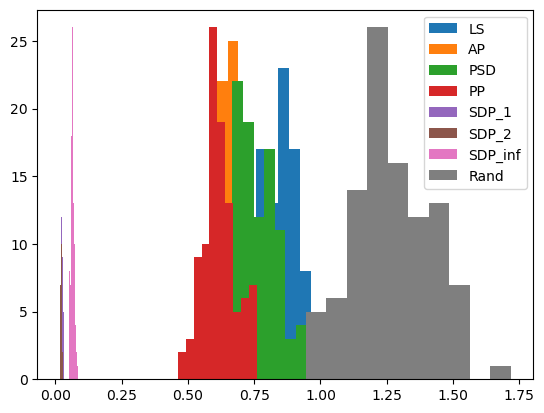

In [124]:
#diamond_error_PP = np.load("out.npy")

for i in range(len(M_est)):
    plt.hist(diamond_error[i],label=M_met[i])
    
plt.legend()


(0.0, 0.8)

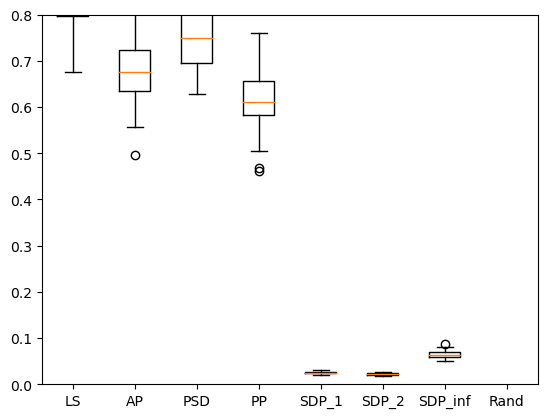

In [127]:

fig, ax = plt.subplots()
ax.boxplot([diamond_error[i] for i in range(len(M_met))])
ax.set_xticklabels(M_met)
plt.ylim([0,0.8])

# PP vs SDP

In [3]:
def LS_operator(d,r,k,n_samp):
    error = np.zeros(1)
    #draw random POVM M, and random Haar-ensbl
    M = rand_POVM(k,d,r)
    ensbl = randh_state_ensbl(d,n_samp)
    #estimates
    M_est = np.empty(1,dtype=list)
    M_est[0] = OS_POVM_Estimator(M,ensbl)
    #compute errors
    error[0] = operator_distance(M,M_est[0])
    
    return error

def LS_diamond(d,r,k,n_samp):
    diamond_error = np.zeros(1)
    #draw random POVM M, and random Haar-ensbl
    M = rand_POVM(k,d,r)
    ensbl = randh_state_ensbl(d,n_samp)
    #estimates
    M_est = np.empty(1,dtype=list)
    M_est[0] = OS_POVM_Estimator(M,ensbl)
    #compute errors
    diamond_error[0] = diamond_distance(M,M_est[0])
    #diamond_error[1] = operator_distance(M,M_est[0])
    
    return diamond_error
    
def mets_diamond(d,r,k,n_samp):
    mets = 5
    diamond_error = np.zeros(mets)
    #draw random POVM M, and random Haar-ensbl
    M = rand_POVM(k,d,r)
    ensbl = randh_state_ensbl(d,n_samp)
    #estimates
    M_est = np.empty(mets,dtype=list)
    
    M_est[0] = OS_POVM_Estimator(M,ensbl)
    
    M_est[1] = M_est[0]
    for i in range(10):
        M_est[1] = PSD_P(M_est[1])
        M_est[1] = POVM_Affine_P(M_est[1])
        
    _,M_est[2] = CVX_PLS(M_est[0])
    M_est[3],_,_,_ = PLS(M,ensbl,n_samp)
    M_est[4] = randGuess(k,d)
        
    #errors
    for i in range(mets):
        diamond_error[i] = diamond_distance(M,M_est[i])
        
    return diamond_error

def PPvSDP(mets,d,r,k,n_samp):
    diamond_error = np.zeros(mets)
    #draw random POVM M, and random Haar-ensbl
    M = rand_POVM(k,d,r)
    ensbl = randh_state_ensbl(d,n_samp)
    #estimates
    M_est = np.empty(mets,dtype=list)
    M_est[0] = OS_POVM_Estimator(M,ensbl)
    M_est[1] = M_est[0]
    for _ in range(3): 
        M_est[1] = PSD_P(M_est[1])
        M_est[1] = POVM_Affine_P(M_est[1])

    M_est[2],_,_,_ = PLS(M,ensbl,n_samp)
    M_est[3],_,_,_ = PLS(M,ensbl,n_samp)
    M_est[4],_,_,_ = PLS(M,ensbl,n_samp)
    
    #compute errors
    for i in range(mets):
        diamond_error[i] = diamond_distance(M,M_est[i])
        
    return diamond_error

def randGuess_error(d,r,k):
    diamond_error = 0.0
    #draw random POVM M, and random Haar-ensbl
    M = rand_POVM(k,d,r)
    ensbl = randh_state_ensbl(d,n_samp)
    #estimates
    M_est = randGuess(k,d)
    #compute errors
    diamond_error = diamond_distance(M,M_est)

    return diamond_error

def APLS_diamond(d,r,k,n_samp,AP):
    diamond_error = np.zeros(AP+1)
    #draw random POVM M, and random Haar-ensbl
    M = rand_POVM(k,d,r)
    ensbl = randh_state_ensbl(d,n_samp)
    #estimates
    M_est = np.empty(2,dtype=list)
    
    M_est[0] = OS_POVM_Estimator(M,ensbl)
    diamond_error[0] = diamond_distance(M,M_est[0])
    
    M_est[1] = PSD_P(M_est[0])
    M_est[1] = POVM_Affine_P(M_est[1])
    
    for i in range(AP):
        diamond_error[i+1] = diamond_distance(M,M_est[1])
        M_est[1] = PSD_P(M_est[1])
        M_est[1] = POVM_Affine_P(M_est[1])
        
    return diamond_error
        

In [4]:
#[d,r,k,n_samp]#

mets=5

### N ###
N_params = [[8,2,4],[6,6,3],[3,1,3]]
N_range = [np.arange(50,1050,50),np.arange(50,1050,50),np.arange(50,1050,50)]

### d ###
d_params = [[5,10,100],[7,5,100],[6,3,100]]
d_range = [np.arange(2,17,1),np.arange(2,17,1),np.arange(2,17,1)]

### K ###
K_params = [[10,5,100],[6,3,100],[3,2,100]]
K_range = [np.arange(2,17,1),np.arange(2,17,1),np.arange(2,17,1)]

N = 100
for j in range(3):
    print("Params: (r,k,n)=({},{},{})".format(d_params[j][0],d_params[j][1],d_params[j][2]))
    for i in d_range[j]:
        r,k,n_samp = d_params[j]
        d=i
        
        t = time.time()
        results = Parallel(n_jobs=64)(delayed(mets_diamond)(d,r,k,n_samp) for _ in range(N))
        print("Time: {} | d = {}".format(time.time() - t, d))
        
        diamond_error = np.concatenate(results,axis=0).reshape((N,mets)).T
    
        np.save("./QMT/mets_diamond_d/P_drkn_{}_{}_{}_{}.npy".format(d,r,k,n_samp),diamond_error)


Params: (r,k,n)=(7,5,100)


/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.


/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.

/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


Time: 7.180043935775757 | d = 2
Time: 6.2882795333862305 | d = 3
Time: 9.625380277633667 | d = 4
Time: 36.66141390800476 | d = 5
Time: 18.630075693130493 | d = 6
Time: 25.518067121505737 | d = 7
Time: 62.85622525215149 | d = 8
Time: 61.02548265457153 | d = 9
Time: 213.3436098098755 | d = 10
Time: 204.30413937568665 | d = 11
Time: 169.33881211280823 | d = 12
Time: 137.75988960266113 | d = 13
Time: 214.21729946136475 | d = 14
Time: 507.01426887512207 | d = 15


/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilati

/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up co

Time: 339.08309507369995 | d = 16
Params: (r,k,n)=(6,3,100)
Time: 2.9327073097229004 | d = 2
Time: 4.051266431808472 | d = 3
Time: 4.053035259246826 | d = 4
Time: 4.930881500244141 | d = 5
Time: 11.871077537536621 | d = 6
Time: 8.503833293914795 | d = 7
Time: 10.409451484680176 | d = 8
Time: 21.38291335105896 | d = 9
Time: 17.137796640396118 | d = 10
Time: 21.516242742538452 | d = 11
Time: 39.40733194351196 | d = 12
Time: 35.504305839538574 | d = 13
Time: 41.10747838020325 | d = 14
Time: 71.23027300834656 | d = 15
Time: 66.45484185218811 | d = 16


In [4]:
### N ###
N_params = [[8,2,4],[6,6,3],[3,1,3]]
N_range = [np.arange(50,1050,50),np.arange(50,1050,50),np.arange(50,1050,50)]

### K ###
K_params = [[6,3,100],[3,2,100]] #[[10,5,100],[6,3,100],[3,2,100]]
K_range = [np.arange(2,15,1),np.arange(2,15,1)]

In [6]:
N = 100
for j in range(3):
    print("Params: (d,r,k)=({},{},{})".format(N_params[j][0],N_params[j][1],N_params[j][2]))
    for i in N_range[j]:
        d,r,k = N_params[j]
        n_samp=i
        
        t = time.time()
        results = Parallel(n_jobs=64)(delayed(mets_diamond)(d,r,k,n_samp) for _ in range(N))
        print("Time: {} | N = {}".format(time.time() - t, n_samp))
        
        diamond_error = np.concatenate(results,axis=0).reshape((N,mets)).T
    
        np.save("./QMT/mets_diamond_n/P_drkn_{}_{}_{}_{}.npy".format(d,r,k,n_samp),diamond_error)

Params: (d,r,k)=(8,2,4)
Time: 52.809677600860596 | N = 50


/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.

/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up co

/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to 

/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


Time: 40.23809838294983 | N = 100
Time: 56.769710540771484 | N = 150
Time: 49.27221179008484 | N = 200
Time: 89.17277121543884 | N = 250
Time: 66.33729815483093 | N = 300
Time: 68.50730323791504 | N = 350
Time: 67.27618741989136 | N = 400
Time: 57.85249996185303 | N = 450
Time: 73.52871108055115 | N = 500
Time: 71.94400691986084 | N = 550
Time: 65.7577292919159 | N = 600
Time: 81.67493939399719 | N = 650
Time: 118.93606328964233 | N = 700
Time: 85.4009644985199 | N = 750
Time: 81.32796120643616 | N = 800
Time: 81.3260293006897 | N = 850
Time: 97.05484914779663 | N = 900
Time: 103.41352105140686 | N = 950
Time: 104.30335903167725 | N = 1000
Params: (d,r,k)=(6,6,3)
Time: 15.117490530014038 | N = 50
Time: 10.57749056816101 | N = 100
Time: 12.484635591506958 | N = 150
Time: 12.792195320129395 | N = 200
Time: 15.280788898468018 | N = 250
Time: 12.464915990829468 | N = 300
Time: 18.089312314987183 | N = 350
Time: 19.06923270225525 | N = 400
Time: 14.69348669052124 | N = 450
Time: 24.06337642

In [6]:
mets = 5
N = 100
for j in range(2):
    print("Params: (d,r,n_samp)=({},{},{})".format(K_params[j][0],K_params[j][1],K_params[j][2]))
    for i in K_range[j]:
        d,r,n_samp = K_params[j]
        k=i
        
        t = time.time()
        results = Parallel(n_jobs=64)(delayed(mets_diamond)(d,r,k,n_samp) for _ in range(N))
        print("Time: {} | k = {}".format(time.time() - t, k))
        
        diamond_error = np.concatenate(results,axis=0).reshape((N,mets)).T
    
        np.save("./QMT/mets_diamond_k/P_drkn_{}_{}_{}_{}.npy".format(d,r,k,n_samp),diamond_error)

Params: (d,r,n_samp)=(6,3,100)
Time: 3.14562726020813 | k = 2
Time: 7.429852724075317 | k = 3


/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.

/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up co

/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.


/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


Time: 32.87499284744263 | k = 4
Time: 46.537089347839355 | k = 5
Time: 78.26837086677551 | k = 6
Time: 89.13149309158325 | k = 7
Time: 153.44619345664978 | k = 8
Time: 135.8844873905182 | k = 9
Time: 358.66917419433594 | k = 10
Time: 367.7351987361908 | k = 11
Time: 413.8819410800934 | k = 12
Time: 852.7398600578308 | k = 13


/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.

/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.

/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code

/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code

Time: 1543.6481127738953 | k = 14
Params: (d,r,n_samp)=(3,2,100)
Time: 4.107731342315674 | k = 2
Time: 3.459681272506714 | k = 3


/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.

/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.


/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilati

/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.

Time: 4.534251689910889 | k = 4
Time: 7.267663240432739 | k = 5
Time: 13.446245193481445 | k = 6
Time: 14.012434959411621 | k = 7
Time: 22.407013177871704 | k = 8
Time: 37.48982548713684 | k = 9
Time: 27.477850437164307 | k = 10
Time: 42.008171796798706 | k = 11
Time: 88.96294283866882 | k = 12
Time: 54.88523817062378 | k = 13
Time: 82.30503821372986 | k = 14


In [21]:

d,r,k,n_samp = [6,6,3,100]

N=10000

t = time.time()
results = Parallel(n_jobs=64)(delayed(randGuess_error)(d,r,k) for _ in range(N))
print(time.time() - t)

avgRandGuess = np.mean(results)
print(avgRandGuess)


28.085425853729248
1.2759119608681242


In [7]:
#10000 statistics
medianRandGuess = 1.2759119608681242
avgRandGuess = 1.282127950281489

In [ ]:
for i in range(4000,11000,1000):
    N = 100
    d,r,k,n_samp = [6,6,3,i]
    
    M_met = ["LS","PP","SDP_1","SDP_2","SDP_inf"]
    mets = len(M_met)
    
    t = time.time()
    results = Parallel(n_jobs=64)(delayed(PPvSDP)(mets,d,r,k,n_samp) for _ in range(N))
    print("Time: {} | n_samp = {}".format(time.time() - t, i))
    
    diamond_error = np.concatenate(results,axis=0).reshape((N,mets)).T

    np.save("./QMT/runs_2/PPvSDP_n{}.npy".format(n_samp),diamond_error)

/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.

/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.

/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #1 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #1 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #1 contains too many subexpressions. Consider vectorizing your CVXPY code

/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #1 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #1 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #1 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #1 contains too many subexpressions. Consider vectorizing your CVXPY code

/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #1 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #1 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #1 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/henning/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:163: UserWarning: Constraint #1 contains too many subexpressions. Consider vectorizing your CVXPY code

(50.0, 1000.0)

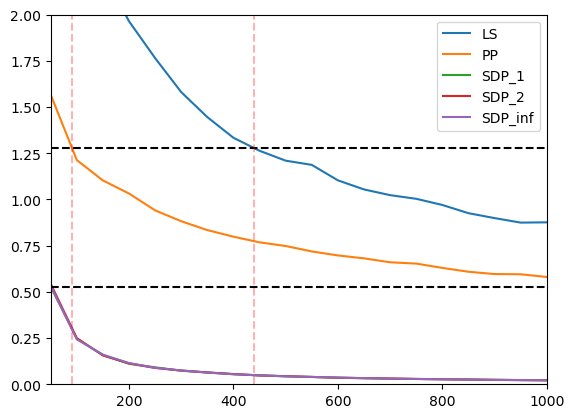

In [8]:
#10000 statistics for random POVM guess
medianRandGuess = 1.2759119608681242
avgRandGuess = 1.282127950281489

M_met = ["LS","PP","SDP_1","SDP_2","SDP_inf"]
mets = len(M_met)

x = np.arange(50,1050,50)

median_error = np.zeros((mets,len(x)))
for i in range(mets):
    for j in range(len(x)):
        median_error[i][j] = np.median(np.load("./QMT/runs_2/PPvSDP_n{}.npy".format(x[j]))[i])

for i in range(mets):
    plt.plot(x,median_error[i],label=M_met[i])

plt.axline((0,medianRandGuess),(1,medianRandGuess),linestyle='--',color='k')
plt.axline((0,median_error[2][0]),(1,median_error[2][0]),linestyle='--',color='k')

plt.axline((90,medianRandGuess),(90,2),linestyle='--',color='r',alpha=.3)
plt.axline((440,0),(440,1),linestyle='--',color='r',alpha=.3)

plt.legend()
plt.ylim([0,2])
plt.xlim([50,1000])

# Analytical guarantee vs LS numerical (OP-distance)

## Fit functions

In [4]:
def d_fit(x,A,B,C,D):
    y = A*x**B*np.log(abs(C*x**D))
    return y

def exp_fit(x,A,B):
    y = A*x**B
    return y


#parameters, covariance = curve_fit(d_fit, list(x), list(median_error))

## N-dependency

In [185]:
for i in range(50,1050,50):
    N = 100
    d,r,k,n_samp = [6,6,3,i]
    d,r,k,n_samp = [3,1,3,i]
    
    M_met = ["LS"]
    mets = len(M_met)
    
    t = time.time()
    results = Parallel(n_jobs=64)(delayed(LS_d)(d,r,k,n_samp) for _ in range(N))
    print("Time: {} | n_samp = {}".format(time.time() - t, i))
    
    operator_error = np.concatenate(results,axis=0).reshape((N,mets)).T

    np.save("./QMT/runs_LS_n/LS_drkn_{}_{}_{}_{}.npy".format(d,r,k,n_samp),operator_error)

Time: 0.31696414947509766 | n_samp = 50
Time: 0.3846416473388672 | n_samp = 100
Time: 0.40044307708740234 | n_samp = 150
Time: 0.4139416217803955 | n_samp = 200
Time: 0.37607312202453613 | n_samp = 250
Time: 0.43114137649536133 | n_samp = 300
Time: 0.40145277976989746 | n_samp = 350
Time: 0.35114598274230957 | n_samp = 400
Time: 0.3429136276245117 | n_samp = 450
Time: 0.34107041358947754 | n_samp = 500
Time: 0.3532528877258301 | n_samp = 550
Time: 0.3620421886444092 | n_samp = 600
Time: 0.3419003486633301 | n_samp = 650
Time: 0.36496806144714355 | n_samp = 700
Time: 0.37006187438964844 | n_samp = 750
Time: 0.3822970390319824 | n_samp = 800
Time: 0.46433353424072266 | n_samp = 850
Time: 0.4743015766143799 | n_samp = 900
Time: 0.4690365791320801 | n_samp = 950
Time: 0.4883708953857422 | n_samp = 1000


[29.50150851 -0.50894063]


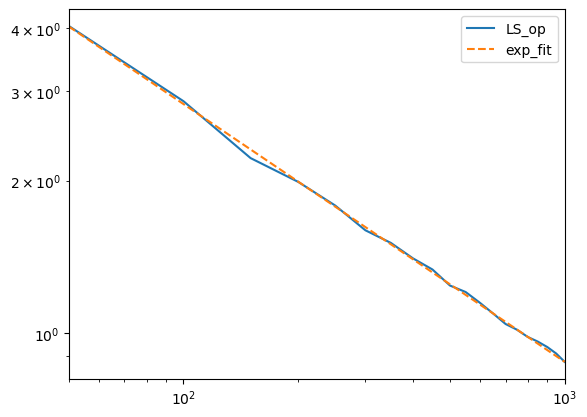

In [7]:
x = np.arange(50,1050,50)
d,r,k = [6,6,3]

median_OPerror = np.zeros(len(x))
for j in range(len(x)):
    median_OPerror[j] = np.median(np.load("./QMT/runs_LS_n/LS_drkn_{}_{}_{}_{}.npy".format(d,r,k,x[j])))


parameters,_ = curve_fit(exp_fit, list(x), list(median_OPerror))

plt.plot(x,median_OPerror,label='LS_op')
plt.loglog(x,[exp_fit(i,parameters[0],parameters[1]) for i in x], linestyle='--',label='exp_fit')
plt.xlim([50,1000])
plt.legend()

print(parameters) #N ~ 1/sqrt(N)

## Diamon-distance LS n_fit  

In [4]:
for i in range(50,1050,50):
    N = 100
    d,r,k,n_samp = [8,2,4,i]
    d,r,k,n_samp = [3,1,3,i]
    
    
    M_met = ["LS"]
    mets = len(M_met)
    
    t = time.time()
    results = Parallel(n_jobs=64)(delayed(LS_diamond)(d,r,k,n_samp) for _ in range(N))
    print("Time: {} | n_samp = {}".format(time.time() - t, i))
    
    operator_error = np.concatenate(results,axis=0).reshape((N,mets)).T

    np.save("./QMT/runs_LS_diamond_n/LS_drkn_{}_{}_{}_{}.npy".format(d,r,k,n_samp),operator_error)

Time: 2.9850828647613525 | n_samp = 50
Time: 0.7841675281524658 | n_samp = 100
Time: 1.0432796478271484 | n_samp = 150
Time: 1.196681022644043 | n_samp = 200
Time: 0.9451045989990234 | n_samp = 250
Time: 1.6176481246948242 | n_samp = 300
Time: 0.8788328170776367 | n_samp = 350
Time: 0.8403520584106445 | n_samp = 400
Time: 0.7766478061676025 | n_samp = 450
Time: 0.8369731903076172 | n_samp = 500
Time: 0.733220100402832 | n_samp = 550
Time: 0.8835246562957764 | n_samp = 600
Time: 0.7915523052215576 | n_samp = 650
Time: 0.8119680881500244 | n_samp = 700
Time: 0.8134334087371826 | n_samp = 750
Time: 0.9121806621551514 | n_samp = 800
Time: 1.0671024322509766 | n_samp = 850
Time: 0.8466508388519287 | n_samp = 900
Time: 0.8883492946624756 | n_samp = 950
Time: 0.902930736541748 | n_samp = 1000


(50, 1000)

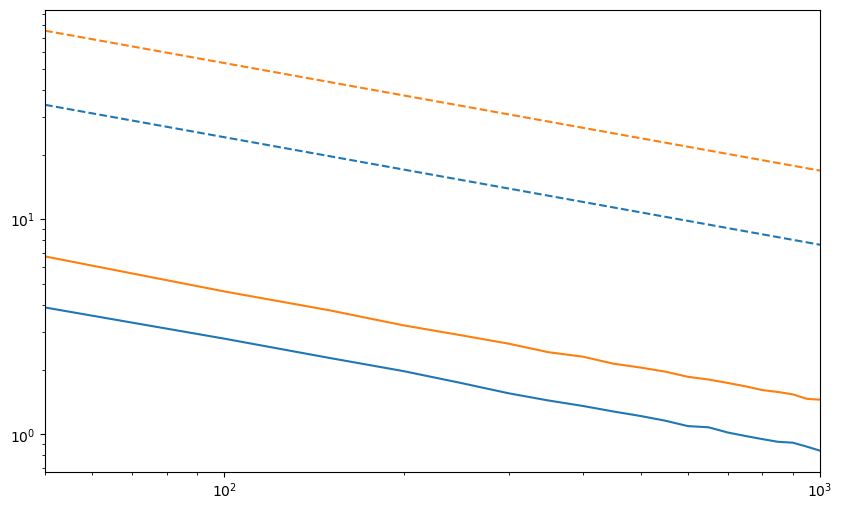

In [60]:
#Probably dont need this for discussion, since we look at the operator-error guarantee
x = np.arange(50,1050,50)

median_error = np.zeros((len(x),len(x)))

for j in range(len(x)):
    d,r,k = [6,6,3]
    median_error[0][j] = np.median(np.load("./QMT/runs_LS_diamond_n/LS_drkn_{}_{}_{}_{}.npy".format(d,r,k,x[j])))
    d,r,k = [8,2,4]
    median_error[1][j] = np.median(np.load("./QMT/runs_LS_diamond_n/LS_drkn_{}_{}_{}_{}.npy".format(d,r,k,x[j])))

    
#parameters,_ = curve_fit(exp_fit, list(x), list(median_error[0]))
    
x = np.arange(50,1050,50)
# worst-case Analytical median error
d,r,k = [6,6,3]
B1 = [ 5*d**1.5*k*math.sqrt(math.log(2*k*d)/(3*N)) for N in x ]

d,r,k = [8,2,4]
B2 = [ 5*d**1.5*k*math.sqrt(math.log(2*k*d)/(3*N)) for N in x ]


fig = plt.figure(figsize=(10,6))
x_labelSize = 16
y_labelSize = 18

plt.plot(x,median_error[0],label='LS_diamond6')
plt.loglog(x,B1, label="Bound6",linestyle="--",color='#1f77b4')

plt.plot(x,median_error[1],label='LS_diamond8')
plt.loglog(x,B2, label="Bound8",linestyle="--",color='#ff7f0e')

plt.xlim([50,1000])
#plt.legend()

#plt.legend(prop={'size': 18});
#plt.xlabel(r"$MC\quad Sweeps$",fontsize=x_labelSize,labelpad=20)
#plt.ylabel(r"$V_{LJTS}\,[\epsilon]\,/\,N_{Box}$",fontsize=y_labelSize,position=(0,.5),labelpad=20)



#print(parameters)

# d-dependency

In [27]:
for i in range(2,21,1):
    N = 100
    d,r,k,n_samp = [i,5,4,100]
    
    M_met = ["cvx","qis","op"]
    mets = len(M_met)
    mets=1
    
    t = time.time()
    results = Parallel(n_jobs=32)(delayed(LS_operator)(d,r,k,n_samp) for _ in range(N))
    print("Time: {} | d = {}".format(time.time() - t, i))
    
    diamond_error = np.concatenate(results,axis=0).reshape((N,mets)).T

    np.save("./QMT/diamond_Qiskit_v_CVX/LS_drkn_{}_{}_{}_{}.npy".format(d,r,k,n_samp),diamond_error)

Time: 0.3071281909942627 | d = 2
Time: 0.3358285427093506 | d = 3
Time: 0.33275604248046875 | d = 4
Time: 0.3162498474121094 | d = 5
Time: 0.32337117195129395 | d = 6
Time: 0.333787202835083 | d = 7
Time: 0.3299131393432617 | d = 8
Time: 0.38467955589294434 | d = 9
Time: 0.39681386947631836 | d = 10
Time: 0.3981895446777344 | d = 11
Time: 0.39711499214172363 | d = 12
Time: 0.3883178234100342 | d = 13
Time: 0.40132737159729004 | d = 14
Time: 0.4033067226409912 | d = 15
Time: 0.41756629943847656 | d = 16
Time: 0.39394068717956543 | d = 17
Time: 0.29751157760620117 | d = 18
Time: 0.30025720596313477 | d = 19
Time: 0.36603641510009766 | d = 20


[ 0.00536905  3.57083936 -1.70088002  0.79042494]


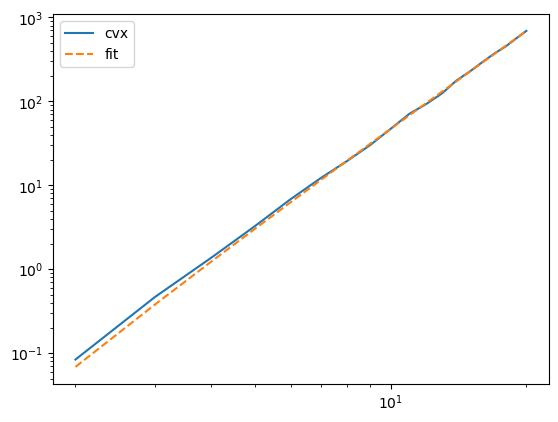

In [28]:
M_met = ["cvx","qis","op"]
mets = len(M_met)
mets=1

r,k,n_samp = [5,4,100]
x = np.arange(2,21,1)

median_error = np.zeros((mets,len(x)))
for i in range(mets):
    for j in range(len(x)):
        median_error[i][j] = np.median(np.load("./QMT/diamond_Qiskit_v_CVX/LS_drkn_{}_{}_{}_{}.npy".format(x[j],r,k,n_samp))[i])**2

for i in range(mets):
    plt.loglog(x,median_error[i],label=M_met[i])

parameters,_ = curve_fit(d_fit, list(x), list(median_error[0]),maxfev=5000)
print(parameters) #d ~ d^2?
plt.plot(x,[d_fit(i,parameters[0],parameters[1],parameters[2],parameters[3]) for i in x], linestyle='--',label='fit')

plt.legend()

In [11]:
#for i in range(18,51,1):
#    N = 100
#    d,r,k,n_samp = [i,5,10,100]

for i in range(2,5,1):
    N = 100
    d,r,k,n_samp = [i,5,10,100]
    
    M_met = ["LS"]
    mets = len(M_met)
    
    t = time.time()
    results = Parallel(n_jobs=64)(delayed(LS_diamond)(d,r,k,n_samp) for _ in range(N))
    print("Time: {} | d = {}".format(time.time() - t, i))
    
    diamond_error = np.concatenate(results,axis=0).reshape((N,mets)).T

    #np.save("./QMT/runs_LS_d/LS_drkn_{}_{}_{}_{}.npy".format(d,r,k,n_samp),operator_error)
    np.save("./QMT/runs_diaCVX_LS_d/LS_drkn_{}_{}_{}_{}.npy".format(d,r,k,n_samp),diamond_error)

Time: 4.16879940032959 | d = 2
Time: 6.880868434906006 | d = 3
Time: 51.330673694610596 | d = 4


[1.67010982e-01 1.91772612e+00 1.44587527e+00 8.59431024e-05]


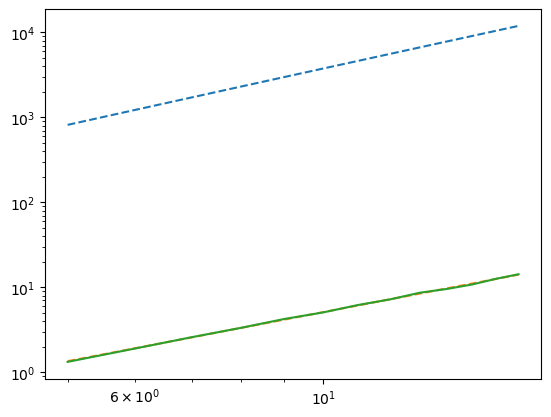

In [31]:


r,k,n_samp = [4,7,100]
x = np.arange(r,29,1)

r,k,n_samp = [5,10,100]
x = np.arange(r,18,1)

B = [ 21.3*d**2*k**2*math.log(2*k*d)/(3*n_samp) for d in x ]

median_error = np.zeros(len(x))
for j in range(len(x)):
    median_error[j] = np.median(np.load("./QMT/runs_LS_d/LS_drkn_{}_{}_{}_{}.npy".format(x[j],r,k,n_samp)))
    #median_error[j] = np.median(np.load("./QMT/runs_diaCVX_LS_d/LS_drkn_{}_{}_{}_{}.npy".format(x[j],r,k,n_samp)))

plt.plot(x,B, label="Bound7",linestyle="--")
  
parameters,_ = curve_fit(d_fit, list(x), list(median_error),maxfev=5000)
print(parameters) #d ~ d^2?
plt.plot(x,[d_fit(i,parameters[0],parameters[1],parameters[2],parameters[3]) for i in x], linestyle='--',label='fit')

plt.loglog(x,median_error,label='LS_diamond_6')

[5.91832094e-02 2.94931934e+00 1.78461099e+00 1.13979012e-04]


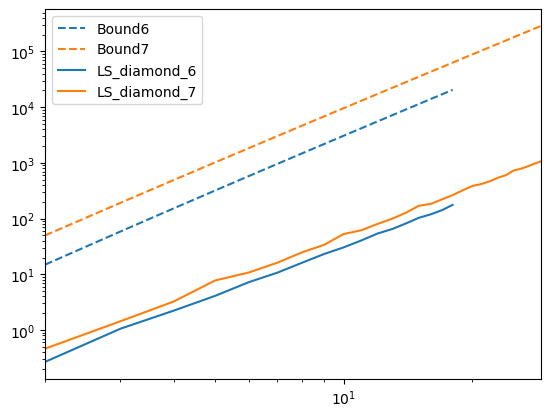

In [9]:

r,k,n_samp = [6,3,100] #Direct comparisson
x1 = np.arange(2,19,1)
B1 = [ 25*d**3*k**2*math.log(2*k*d)/(3*n_samp) for d in x1 ]

median_error_1 = np.zeros(len(x1))
for j in range(len(x1)):
    #median_error[j] = np.median(np.load("./QMT/runs_LS_d/LS_drkn_{}_{}_{}_{}.npy".format(x[j],r,k,n_samp)))
    median_error_1[j] = np.median(np.load("./QMT/runs_diaCVX_LS_d/LS_drkn_{}_{}_{}_{}.npy".format(x1[j],r,k,n_samp)))**2

#r,k,n_samp = [5,10,100]     

r,k,n_samp = [7,5,100] #
x2 = np.arange(2,30,1)
B2 = [ 25*d**3*k**2*math.log(2*k*d)/(3*n_samp) for d in x2 ]

median_error_2 = np.zeros(len(x2))
for j in range(len(x2)):
    median_error_2[j] = np.median(np.load("./QMT/runs_diaCVX_LS_d/LS_drkn_{}_{}_{}_{}.npy".format(x2[j],r,k,n_samp)))**2

    
# PLOTS
plt.plot(x1,B1, label="Bound6",linestyle="--")
plt.plot(x2,B2, label="Bound7",linestyle="--")
  
parameters,_ = curve_fit(d_fit, list(x1), list(median_error_1),maxfev=5000)
print(parameters) #d ~ d^2?
#plt.plot(x1,[d_fit(i,parameters[0],parameters[1],parameters[2],parameters[3]) for i in x1], linestyle='--',label='fit')

plt.plot(x1,median_error_1,label='LS_diamond_6', color='#1f77b4')
plt.loglog(x2,median_error_2,label='LS_diamond_7',color='#ff7f0e')

plt.xlim([min(x2),max(x2)])
#plt.ylim([0,50])

plt.legend()

## k-dependency

In [ ]:
for i in range(2,101,1):
    N = 100
    d,r,k,n_samp = [3,2,i,100]
    
    M_met = ["cvx_diamond","op"]
    mets = len(M_met)
    #mets=1
    
    t = time.time()
    results = Parallel(n_jobs=64)(delayed(LS_diamond)(d,r,k,n_samp) for _ in range(N))
    print("Time: {} | k = {}".format(time.time() - t, i))
    
    operator_error = np.concatenate(results,axis=0).reshape((N,mets)).T

    np.save("./QMT/runs_LS_diamond_k/LS_drkn_{}_{}_{}_{}.npy".format(d,r,k,n_samp),operator_error)

Time: 2.4412026405334473 | k = 2
Time: 2.0816233158111572 | k = 3
Time: 1.3498406410217285 | k = 4
Time: 1.9030332565307617 | k = 5
Time: 6.925631761550903 | k = 6
Time: 2.930529832839966 | k = 7
Time: 4.1916821002960205 | k = 8
Time: 5.454015016555786 | k = 9
Time: 5.956464529037476 | k = 10
Time: 8.351677179336548 | k = 11
Time: 22.5867760181427 | k = 12
Time: 10.65868616104126 | k = 13
Time: 36.78178906440735 | k = 14
Time: 75.05611753463745 | k = 15
Time: 47.7909722328186 | k = 16
Time: 75.30362462997437 | k = 17
Time: 43.38578653335571 | k = 18
Time: 58.408830642700195 | k = 19
Time: 56.61520504951477 | k = 20
Time: 162.49869203567505 | k = 21
Time: 98.19936537742615 | k = 22
Time: 123.781409740448 | k = 23
Time: 346.7263207435608 | k = 24
Time: 321.27704334259033 | k = 25
Time: 185.52905464172363 | k = 26
Time: 99.34817457199097 | k = 27
Time: 204.09683465957642 | k = 28
Time: 167.41130232810974 | k = 29
Time: 779.2907056808472 | k = 30
Time: 492.0961084365845 | k = 31
Time: 173.

/tmp/ipykernel_3541259/3097557372.py:2: RuntimeWarning: divide by zero encountered in log
  y = A*x**B*np.log(abs(C*x**D))


[1.34008452 0.82955011 1.27263245 0.03098348]


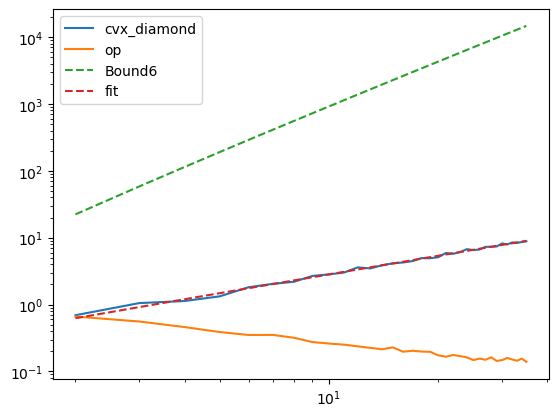

In [6]:
d,r,n_samp = [10,5,100]
x = np.arange(2,17,1)

d,r,n_samp = [3,2,100]
x = np.arange(2,36,1)

#d,r,n_samp = [6,3,100] #Direct Comparisson
#x = np.arange(2,25,1)
B1 = [ 25*d**3*k**2*math.log(2*k*d)/(3*n_samp) for k in x ]

M_met = ["cvx_diamond","op"]
mets = len(M_met)

median_error = np.zeros((mets,len(x)))
for i in range(mets):
    for j in range(len(x)):
        median_error[i][j] = np.median(np.load("./QMT/runs_LS_diamond_k/LS_drkn_{}_{}_{}_{}.npy".format(d,r,x[j],n_samp))[i])**2
                        
parameters,_ = curve_fit(d_fit, list(x), list(median_error[0]), maxfev=5000)

for i in range(mets):
    plt.plot(x,median_error[i],label=M_met[i])
    
scaled_error = np.zeros(len(x))
for j in range(len(x)):
    scaled_error[j] = np.median(np.load("./QMT/runs_LS_diamond_k/LS_drkn_{}_{}_{}_{}.npy".format(d,r,x[j],n_samp))[1])*x[j]


#plt.loglog(x,scaled_error,label='Scaled OP')   

plt.loglog(x,B1, label="Bound6",linestyle="--")
                        
plt.plot(x,[d_fit(i,parameters[0],parameters[1],parameters[2],parameters[3]) for i in x], linestyle='--',label='fit')
#plt.xlim([min(x),max(x)])
plt.legend()

print(parameters) #k ~ k^-4/3 #

In [275]:
for i in range(2,101,1):
    N = 100
    d,r,k,n_samp = [10,5,i,100]
    
    M_met = ["LS"]
    mets = len(M_met)
    
    t = time.time()
    results = Parallel(n_jobs=64)(delayed(LS_operator)(d,r,k,n_samp) for _ in range(N))
    print("Time: {} | k = {}".format(time.time() - t, i))
    
    operator_error = np.concatenate(results,axis=0).reshape((N,mets)).T

    np.save("./QMT/runs_LS_k/LS_drkn_{}_{}_{}_{}.npy".format(d,r,k,n_samp),operator_error)

Time: 0.9758713245391846 | k = 2
Time: 0.3599965572357178 | k = 3
Time: 0.3808152675628662 | k = 4
Time: 0.39095139503479004 | k = 5
Time: 0.3663763999938965 | k = 6
Time: 0.36882662773132324 | k = 7
Time: 0.3792252540588379 | k = 8
Time: 0.362506628036499 | k = 9
Time: 0.3938107490539551 | k = 10
Time: 0.3851287364959717 | k = 11
Time: 0.384429931640625 | k = 12
Time: 0.36213016510009766 | k = 13
Time: 0.3703763484954834 | k = 14
Time: 0.36821961402893066 | k = 15
Time: 0.3733031749725342 | k = 16
Time: 0.3649601936340332 | k = 17
Time: 0.40273070335388184 | k = 18
Time: 0.40510106086730957 | k = 19
Time: 0.3443565368652344 | k = 20
Time: 0.3420116901397705 | k = 21
Time: 0.3750019073486328 | k = 22
Time: 0.343707799911499 | k = 23
Time: 0.3528144359588623 | k = 24
Time: 0.40274667739868164 | k = 25
Time: 0.3766360282897949 | k = 26
Time: 0.3577723503112793 | k = 27
Time: 0.3714756965637207 | k = 28
Time: 0.4148104190826416 | k = 29
Time: 0.39060187339782715 | k = 30
Time: 0.436687707

[37.78909258  0.79804891]


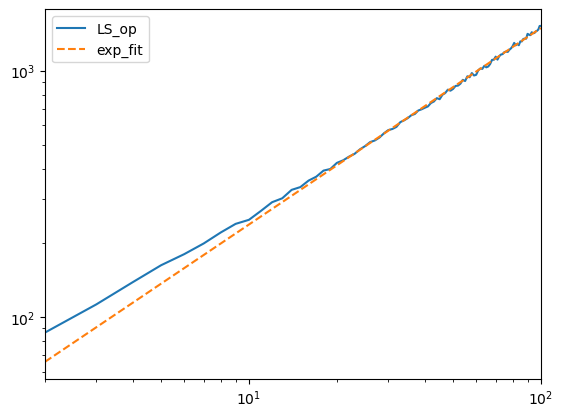

In [47]:
#d,r,n_samp = [4,2,100]
#x = np.arange(2,51,1)

d,r,n_samp = [10,5,100]
x = np.arange(2,101,1)

median_OPerror = np.zeros(len(x))
for j in range(len(x)):
    median_OPerror[j] = np.median(np.load("./QMT/runs_LS_k/LS_drkn_{}_{}_{}_{}.npy".format(d,r,x[j],n_samp)))*x[j]*r

parameters,_ = curve_fit(exp_fit, list(x), list(median_OPerror))

plt.loglog(x,median_OPerror,label='LS_op')
plt.plot(x,[exp_fit(i,parameters[0],parameters[1]) for i in x], linestyle='--',label='exp_fit')
plt.xlim([min(x),max(x)])
plt.legend()

print(parameters) #k ~ k^-4/3 #

# AP Projections

# d,k-dimension

In [76]:
N = 100
AP = 40 #Takes 40min
d,r,k,n_samp = [5,5,4,100]
d,r,k,n_samp = [0,6,3,100] #for d
d,r,k,n_samp = [3,2,0,100] #for k
d,r,k,n_samp = [7,0,7,100] #for r

for r in np.arange(1,2,1):
    t = time.time()
    results = Parallel(n_jobs=64)(delayed(APLS_diamond)(d,r,k,n_samp,AP) for _ in range(N))
    print("Time: {}".format(time.time() - t)," r = {} ".format(r))
    
    np.save("./QMT/runs_APLS_r/AP_{}_{}_{}_{}_AP{}.npy".format(d,r,k,n_samp,AP),results)

#diamond_error = 1/N*np.asarray(results).sum(axis=0) # Average

Time: 1008.7615149021149  r = 1 
Time: 991.5383336544037  r = 2 
Time: 903.5452408790588  r = 3 
Time: 746.8196699619293  r = 4 
Time: 831.5575525760651  r = 5 
Time: 945.6772077083588  r = 6 
Time: 1063.1752026081085  r = 7 


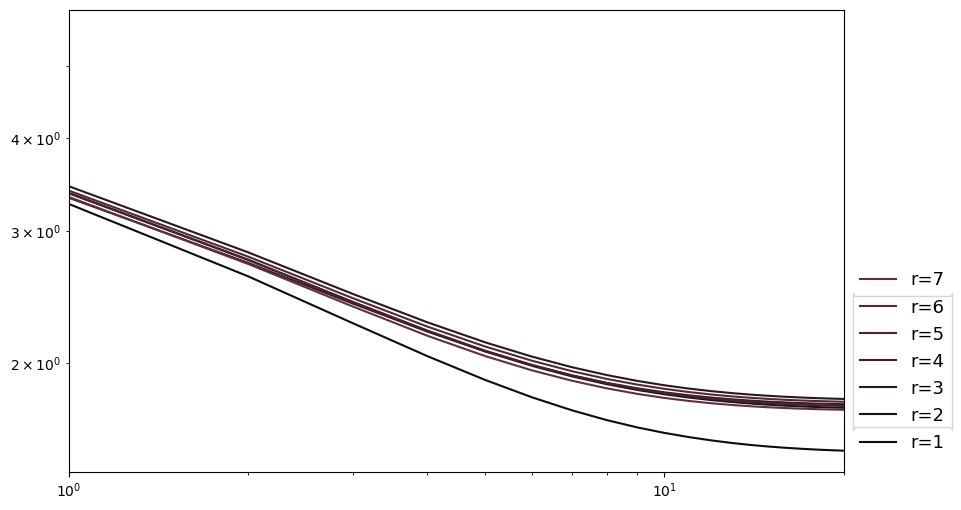

In [78]:
x = np.arange(2,11,2)
d,r,k,n_samp = [5,4,3,100]

# For d
#x = np.arange(2,19,1)
#d,r,k,n_samp = [0,6,3,100]

#for K
#x = np.arange(2,17,1)
#d,r,k,n_samp = [3,2,0,100]

#for r
x = np.arange(1,8,1)
d,r,k,n_samp = [7,0,7,100]



fig = plt.figure(figsize=(10,6))


AP = 20
N=100
y = np.arange(0,AP+1,1)

results = np.empty(len(x),dtype=list)
for i in range(len(x)):
    results[i] = np.load("./QMT/runs_APLS_r/AP_{}_{}_{}_{}_AP{}.npy".format(d,x[i],k,n_samp,AP))
    plt.loglog(y,1/N*np.asarray(results[i]).sum(axis=0),label="r={}".format(x[i]),color=((10+i*15)/255,(15+i*5)/255,(10+i*10)/255))

plt.xlim([1,20])
#plt.ylim([1,9])

fig.legend(loc='upper left', bbox_to_anchor=(0.9, 0.2),prop={'size': 13}, ncol=1,labelspacing=-2.5)

In [6]:
print(1/N*np.asarray(results[i]).sum(axis=0))

[6.33732753 3.63205793 2.7712618  2.32432176 2.05692423 1.88684713
 1.7747134  1.69957468 1.64822841 1.61249983 1.58743842 1.56966237
 1.55693473 1.5477751  1.54114794 1.53632772 1.53281118 1.53023648
 1.52835525 1.52697019 1.52594788]


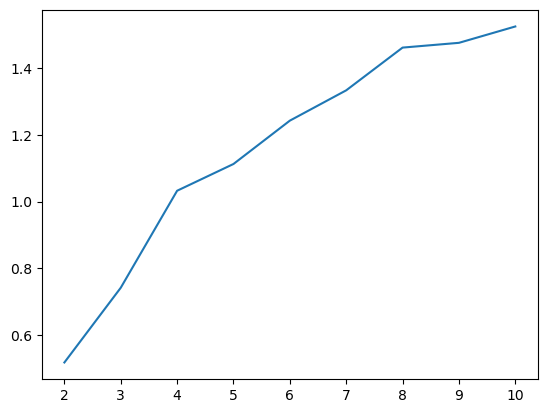

In [8]:
#Saturation error

plt.plot(x,[min(1/N*np.asarray(results[i]).sum(axis=0)) for i in range(len(x)) ])


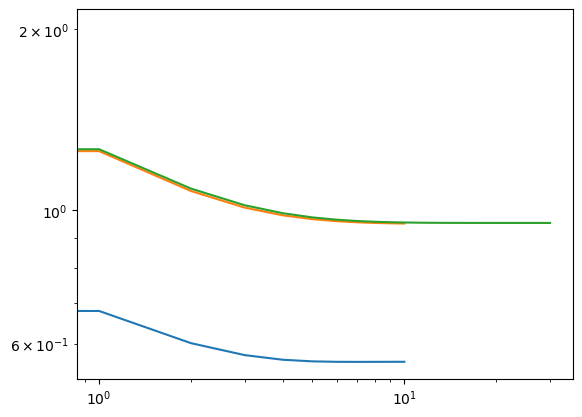

In [26]:
AP =10
plt.loglog(np.arange(0,AP+1,1),1/N*np.asarray(results1).sum(axis=0),1/N*np.asarray(results2).sum(axis=0))
AP=30
plt.plot(np.arange(0,AP+1,1),diamond_error)
#plt.xlim([6,10])
#plt.ylim([0,.6])

#do for different dims and Ks to see where it saturates
#(two plots, one for d, one for K)

In [16]:
plt.plot(np.arange(0,AP,1),diamond_error)

[2.20768686 1.56898504 1.43224423 1.40048447 1.38755675 1.38137275
 1.37821747 1.37653476 1.37560814 1.37506519 1.37478576]


In [ ]:
d,r,n_samp = [10,5,100]
x = np.arange(1,2,1)

median_error = np.empty(len(x),dtype=list)
for j in range(len(x)):
    median_error[j] = np.load("./QMT/runs_LS_k/LS_drkn_{}_{}_{}_{}.npy".format(d,r,x[j],n_samp))

parameters,_ = curve_fit(exp_fit, list(x), list(median_OPerror))

plt.loglog(x,median_OPerror,label='LS_op')
plt.plot(x,[exp_fit(i,parameters[0],parameters[1]) for i in x], linestyle='--',label='exp_fit')
plt.xlim([min(x),max(x)])
plt.legend()

print(parameters) #k ~ k^-4/3 #

## Operator norm dependance on k (due to unity POVM condition)

In [36]:
def dkr_fit(x,A,B):
    y = A*x**B
    return y

d,r = [10,5]
k = np.arange(2,1000)

res = np.zeros(len(k))

for i in range(len(k)):
    M = rand_POVM(k[i],d,r)
    res[i] = operator_distance(M,[np.zeros((d,d)) for _ in range(k[i])])*k[i]*r


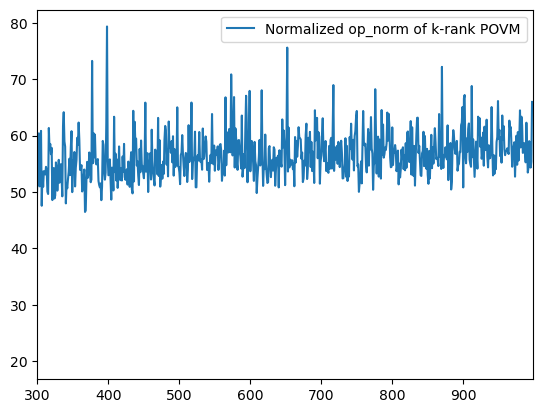

In [49]:
plt.plot(res,label='Normalized op_norm of k-rank POVM')

plt.xlim([300,max(k)])
plt.legend()

# |.|_Op \in [0,1/(kr)] --> Normalized |.|_Op norm for k-rank POVM

## r-dependency

In [ ]:
# r \in [1,d]

for i in range(10,101,1):
    N = 100
    d,r,k,n_samp = [100,i,10,100]
    
    M_met = ["LS"]
    mets = len(M_met)
    
    t = time.time()
    results = Parallel(n_jobs=64)(delayed(LS_diamond)(d,r,k,n_samp) for _ in range(N))
    print("Time: {} | r = {}".format(time.time() - t, i))
    
    operator_error = np.concatenate(results,axis=0).reshape((N,mets)).T

    np.save("./QMT/runs_LS_r/LS_drkn_{}_{}_{}_{}.npy".format(d,r,k,n_samp),operator_error)

[ 4.81914360e+02 -8.76941178e-04]


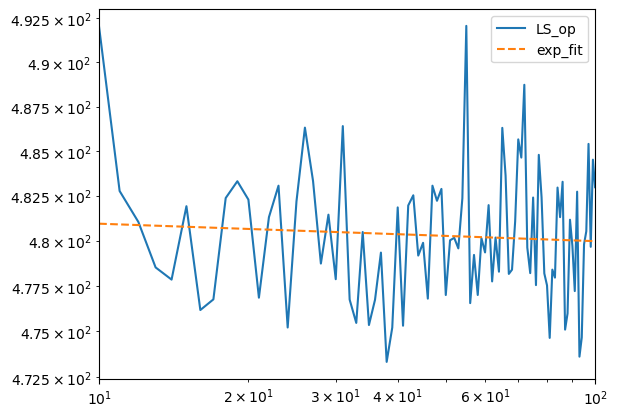

In [10]:
d,k,n_samp = [100,10,100]
x = np.arange(10,101,1)

median_OPerror = np.zeros(len(x))
for j in range(len(x)):
    median_OPerror[j] = np.median(np.load("./QMT/runs_LS_r/LS_drkn_{}_{}_{}_{}.npy".format(d,x[j],k,n_samp)))#*x[j]*k

parameters,_ = curve_fit(exp_fit, list(x), list(median_OPerror))

plt.loglog(x,median_OPerror,label='LS_op')
plt.plot(x,[exp_fit(i,parameters[0],parameters[1]) for i in x], linestyle='--',label='exp_fit')
plt.xlim([min(x),max(x)])
plt.legend()

print(parameters) #r ~ r^0 # No rank dependency, due to r*k>=d |.|_op \in [0,1/d]

## PP_diamond k-dependency

In [ ]:
for i in range(2,31,1):
    N = 100
    d,r,k,n_samp = [3,2,i,100]
    
    M_met = ['LS','PP']
    mets = len(M_met)
    
    t = time.time()
    results = Parallel(n_jobs=64)(delayed(PP_diamond)(d,r,k,n_samp) for _ in range(N))
    print("Time: {} | k = {}".format(time.time() - t, i))
    
    diamond_error = np.concatenate(results,axis=0).reshape((N,mets)).T

    np.save("./QMT/runs_diaCVX_PP/PP_drkn_{}_{}_{}_{}.npy".format(d,r,k,n_samp),diamond_error)
    #np.save("./QMT/runs_LS_k/PP_drkn_{}_{}_{}_{}.npy".format(d,r,k,n_samp),diamond_error)

Time: 1.794036626815796 | k = 2
Time: 1.955801010131836 | k = 3
Time: 2.93770432472229 | k = 4
Time: 1.9088923931121826 | k = 5
Time: 6.0037841796875 | k = 6
Time: 4.097704172134399 | k = 7
Time: 9.024478197097778 | k = 8
Time: 20.3862943649292 | k = 9
Time: 15.173303127288818 | k = 10
Time: 28.800438404083252 | k = 11
Time: 23.15337562561035 | k = 12
Time: 26.3531973361969 | k = 13
Time: 55.71316647529602 | k = 14
Time: 62.98163676261902 | k = 15


### PP diamond-error k-dependency

[2.80017391e-01 9.13048681e-01 1.13196677e+00 2.09774497e-06]


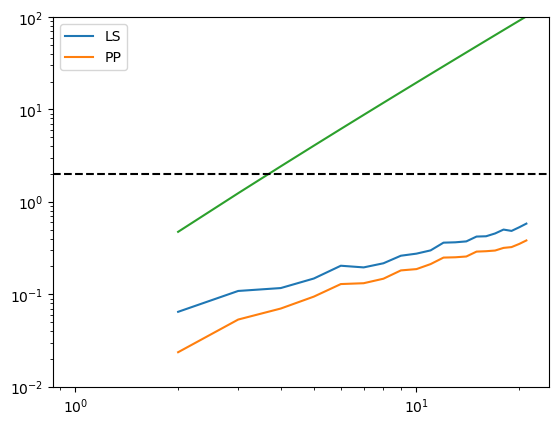

In [6]:
x = np.arange(2,19,1)
d,r,n_samp = [3,2,100]

x = np.arange(2,22,1)
d,r,n_samp = [3,2,1000]

median_error_PP_sq = np.zeros(len(x))
median_error_LS_sq = np.zeros(len(x))
for j in range(len(x)):
    #median_error_sq[j] = np.median(np.load("./QMT/runs_LS_k/PP_drkn_{}_{}_{}_{}.npy".format(d,r,x[j],n_samp)))**2
    median_error_LS_sq[j] = np.median(np.load("./QMT/runs_diaCVX_PP/PP_drkn_{}_{}_{}_{}.npy".format(d,r,x[j],n_samp))[0])**2
    median_error_PP_sq[j] = np.median(np.load("./QMT/runs_diaCVX_PP/PP_drkn_{}_{}_{}_{}.npy".format(d,r,x[j],n_samp))[1])**2
plt.plot(x,median_error_LS_sq,label='LS')
plt.plot(x,median_error_PP_sq,label='PP')

parameters, covariance = curve_fit(d_fit, list(x), list(median_error_LS_sq))

#plt.loglog(x,d_fit(x,parameters[0],parameters[1],parameters[2],parameters[3]))
plt.loglog(x,d_fit(x,5.3*d**2/n_samp,2,2*d,1))
plt.axline((0,2),(1,2),linestyle='--',color='k')
plt.legend()
plt.ylim([0.01,100])

print(parameters)


### LS diamond-error k-dependency

In [9]:
for i in range(18,31,1):
    N = 100
    d,r,k,n_samp = [3,2,i,100]
    
    M_met = ['LS']
    mets = len(M_met)
    
    t = time.time()
    results = Parallel(n_jobs=64)(delayed(LS_diamond)(d,r,k,n_samp) for _ in range(N))
    print("Time: {} | k = {}".format(time.time() - t, i))
    
    diamond_error = np.concatenate(results,axis=0).reshape((N,mets)).T

    np.save("./QMT/runs_diaCVX_LS_k/LS_drkn_{}_{}_{}_{}.npy".format(d,r,k,n_samp),diamond_error)

Time: 81.20856547355652 | k = 18
Time: 41.69251298904419 | k = 19
Time: 95.60614442825317 | k = 20
Time: 126.7377233505249 | k = 21
Time: 138.61251783370972 | k = 22
Time: 156.3737277984619 | k = 23
Time: 233.0471818447113 | k = 24
Time: 89.90152192115784 | k = 25
Time: 251.99133706092834 | k = 26
Time: 288.6048228740692 | k = 27
Time: 207.22663569450378 | k = 28
Time: 365.62502455711365 | k = 29
Time: 608.4328489303589 | k = 30


/tmp/ipykernel_3697290/3876758718.py:2: RuntimeWarning: overflow encountered in power
  y = A*x**B*np.log(abs(C*x**D))


[2.24480534e-01 9.44450585e-01 4.15677444e+00 1.26010607e-05]


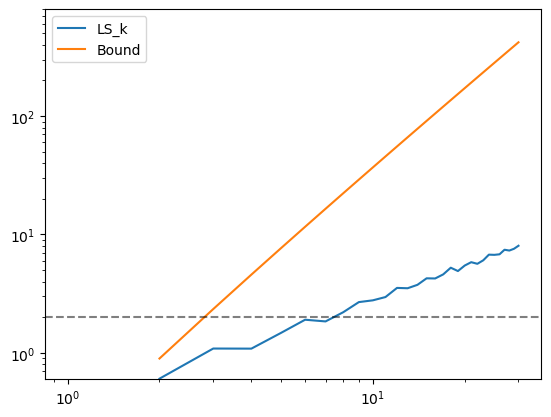

In [13]:
x = np.arange(2,31,1)
d,r,n_samp = [3,2,100]

median_error = np.zeros(len(x))
for j in range(len(x)):
    #median_error[j] = np.median(np.load("./QMT/runs_LS_k/LS_drkn_{}_{}_{}_{}.npy".format(d,r,x[j],n_samp)))
    median_error[j] = np.median(np.load("./QMT/runs_diaCVX_LS_k/LS_drkn_{}_{}_{}_{}.npy".format(d,r,x[j],n_samp)))**2
plt.plot(x,median_error,label='LS_k')

parameters, covariance = curve_fit(d_fit, list(x), list(median_error))

plt.loglog(x,d_fit(x,d**2/n_samp,2,2*d,1),label="Bound")
#plt.loglog(x,d_fit(x,parameters[0],parameters[1],parameters[2],parameters[3]),label='Fit')
plt.ylim([min(median_error),max(median_error*100)])
plt.legend()
plt.axline((0,2),(1,2),linestyle='--',color='k',alpha=.5)

print(parameters)

# rank-dpendency

In [ ]:
for i in range(2,29,1):
    N = 100
    d,r,k,n_samp = [i,4,7,100]
    
    M_met = ["LS"]
    mets = len(M_met)
    
    t = time.time()
    results = Parallel(n_jobs=64)(delayed(LS)(d,r,k,n_samp) for _ in range(N))
    print("Time: {} | d = {}".format(time.time() - t, i))
    
    diamond_error = np.concatenate(results,axis=0).reshape((N,mets)).T

    np.save("./QMT/runs_LS_d/LS_drkn_{}_{}_{}_{}.npy".format(d,r,k,n_samp),diamond_error)

# Zik-Zak Plot

## Different #Nzz

In [1]:
import functions.py

# total arguments
n = len(sys.argv)
params = ["dim: ","rank: ","#eff: ","#sampl: ","#Nzz"]
script,d,r,k,n_samp,Nzz = sys.argv

print("Name of Python script:", sys.argv[0])
print("Arguments passed:", end = " ")
for i in range(1, n):
    print(params[i-1] + sys.argv[i+1], end = " | ")

#d,r,k,n_samp = [6,6,3,10_000] # fixed parameters
N = 100
error = []

for i in range(N):
    #draw random POVM M, and random Haar-ensbl
    M = rand_POVM(k,d,r)
    ensbl = randh_state_ensbl(d,n_samp)
    #estimate
    M_est = OS_POVM_Estimator(M,ensbl)
    for j in range(Nzz):
        M_est = POVM_Affine_P(M_est)
        M_est = PSD_P(M_est)
            
    error.append(diamond_distance(M,M_est))

#np.save("./runs1/{}_d{}_r{}_k{}_n{}_zz{}.npy".format(script,d,r,k,n_samp,Nzz), error)

ValueError: not enough values to unpack (expected 6, got 3)

(0.0, 2.0)

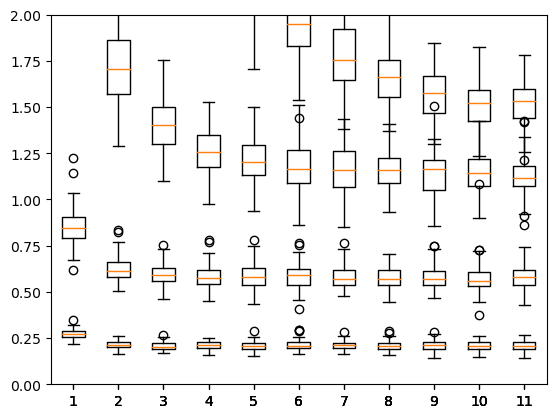

In [27]:

d,r,k,n_samp=[6,6,3,1000]
ZZ_10 = []
ZZ_100 = []
ZZ_1_000 = []
ZZ_10_000 = []

for Nzz in range(11):
    #ZZ_10_000.append(np.load(r'//HAL-7559@discovery-one/home/HAL-7559/Documents/Jupyter/Master/runs_1/diamond_error.py_d{}_r{}_k{}_n{}_zz{}.npy'.format(d,r,k,10000,Nzz)))
    ZZ_10_000.append(np.load("./QMT/runs_1/diamond_error.py_d{}_r{}_k{}_n{}_zz{}.npy".format(d,r,k,10000,Nzz)))
    
for Nzz in range(11):
    #ZZ_1_000.append(np.load("./runs_1/diamond_error.py_d{}_r{}_k{}_n{}_zz{}.npy".format(d,r,k,1000,Nzz)))
    ZZ_1_000.append(np.load("./QMT/runs_1/diamond_error.py_d{}_r{}_k{}_n{}_zz{}.npy".format(d,r,k,1000,Nzz)))
    
for Nzz in range(11):
    #ZZ_100.append(np.load("./runs_1/diamond_error.py_d{}_r{}_k{}_n{}_zz{}.npy".format(d,r,k,100,Nzz)))
    ZZ_100.append(np.load("./QMT/runs_1/diamond_error.py_d{}_r{}_k{}_n{}_zz{}.npy".format(d,r,k,100,Nzz)))
    
for Nzz in range(11):
    #ZZ_10.append(np.load("./runs_1/diamond_error.py_d{}_r{}_k{}_n{}_zz{}.npy".format(d,r,k,10,Nzz)))
    ZZ_10.append(np.load("./QMT/runs_1/diamond_error.py_d{}_r{}_k{}_n{}_zz{}.npy".format(d,r,k,10,Nzz)))

fig, ax_10 = plt.subplots()
#ax_100 = ax_10.twinx()
#ax_1_000 = ax_10.twinx()
#ax_10_000 = ax_10.twinx()

#ax_10.plot([np.mean(ZZ_10[i]) for i in range(11)])
#ax_100.boxplot(ZZ_100)
#ax_1_000.boxplot(ZZ_1_000)
#ax_10_000.boxplot(ZZ_10_000)

ax_10.boxplot(ZZ_10)
ax_10.boxplot(ZZ_100)
ax_10.boxplot(ZZ_1_000)
ax_10.boxplot(ZZ_10_000)
plt.ylim([0,2])

(0.0, 10.0)

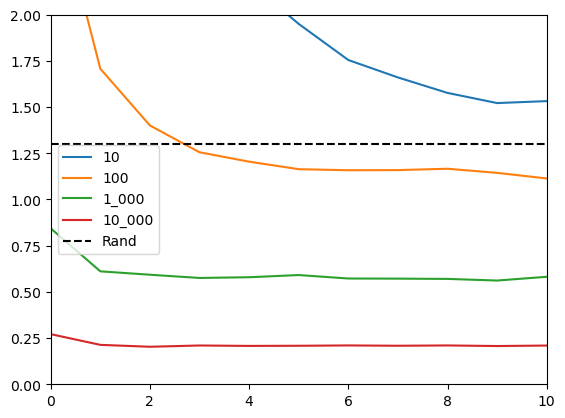

In [50]:
plt.plot([(np.median(ZZ_10[i])) for i in range(11)], label="10")
plt.plot([np.median(ZZ_100[i]) for i in range(11)], label="100")
plt.plot([np.median(ZZ_1_000[i]) for i in range(11)], label="1_000")
plt.plot([np.median(ZZ_10_000[i]) for i in range(11)], label="10_000")

y = np.median(diamond_error[7])
plt.axline((0,y),(1,y),color="k",linestyle="--",label="Rand")

plt.legend()
plt.ylim([0,2])
plt.xlim([0,10])

## Different d

## Different k

## Different n_samp

# Reconstruction error distribution $||_{\text{Op}}$ vs $||_\diamond$

In [3]:
N = 100
d,r,k,n_samp = [6,6,3,10_000]

#d,r,k, n_sampl fixed

op_error = []
diamond_error = []

for i in range(N):
    #draw random POVM M, and random Haar-ensbl
    M = rand_POVM(k,d,r)
    ensbl = randh_state_ensbl(d,n_samp)
    #estimate
    M_E = OS_POVM_Estimator(M,ensbl)
    #compute errors
    op_error.append(operator_distance(M,M_E))
    diamond_error.append(diamond_distance(M,M_E))

In [ ]:

x = [i for i in range(100,10_000, 1000)]

for i in range(len(x)):
    print(i)
    

(array([ 3.,  8., 16., 21., 18., 17., 13.,  2.,  1.,  1.]),
 array([0.20958296, 0.22396145, 0.23833994, 0.25271843, 0.26709691,
        0.2814754 , 0.29585389, 0.31023238, 0.32461087, 0.33898936,
        0.35336785]),
 <BarContainer object of 10 artists>)

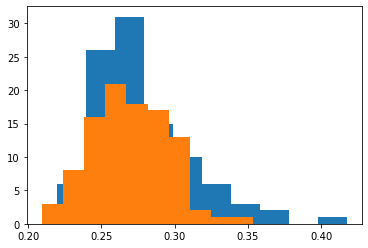

In [8]:
plt.hist(op_error)
plt.hist(diamond_error)

# eintragsweise error -> gauss distributed

{'whiskers': [<matplotlib.lines.Line2D at 0x7f76df1e9540>,
 'caps': [<matplotlib.lines.Line2D at 0x7f76df1e9ae0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f76df1e9270>],
 'medians': [<matplotlib.lines.Line2D at 0x7f76df1ea080>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f76df1ea350>],
 'means': []}

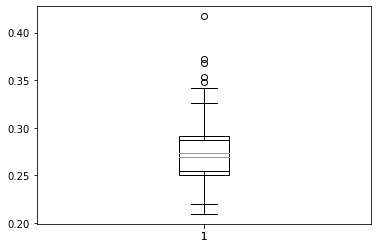

In [6]:
plt.boxplot(op_error)
plt.boxplot(diamond_error)

# Projective LS Estimator via SDP

## Data Generation

In [128]:
L = 20 # Number of probe states (need at least d² many)
samples = 100 # Statistics Samples (100 samples per probe state in ensbl)

d = 4 # Effect's dimension
r = d # Effect's rank
k = 5 # Number of Effects

# Random POVM
M = rand_POVM(k,d,r)

# Haar pure-state ensemble
ensbl = randh_state_ensbl(d,L)

# Statistical frequencies
v = np.asarray(POVM_ensbl_stats(ensbl,M,samples))/samples


## SDP

In [129]:
# SPD solution and constraints' check & violation

POVM_PLS, cost_min, cond_check, cond_violation = PLS(M,ensbl,v)

print("\nThe optimal value is:", cost_min)
print("\nThe optimal LS-POVM is:\n")
for i in range(k):
    print(POVM_PLS[i])
    print()

print("CONSTRAINTS\n\nIdentity:\n\n", np.sum(POVM_PLS,axis=0),"\n\nPositivity:\n")
for i in range(k):
    print("Effect",i,">> 0: ", cond_check[i+1], np.linalg.eigvalsh(POVM_PLS[i]), "\n")
    print("Violation: ", cond_violation[i+1],"\n")
    print()
    


The optimal value is: 0.0252666473301553

The optimal LS-POVM is:

[[ 0.09713032+0.j         -0.10276214+0.00949991j  0.06917899-0.04953751j
  -0.04076805+0.03410543j]
 [-0.10276214-0.00949991j  0.24159476+0.j         -0.10482212-0.03946451j
   0.01537934+0.02528053j]
 [ 0.06917899+0.04953751j -0.10482212+0.03946451j  0.13487003+0.j
  -0.07713681-0.02820083j]
 [-0.04076805-0.03410543j  0.01537934-0.02528053j -0.07713681+0.02820083j
   0.06135767+0.j        ]]

[[ 0.16304397+0.j         -0.01722852+0.0235874j  -0.10249883-0.02761751j
  -0.02371379+0.09190615j]
 [-0.01722852-0.0235874j   0.13257571+0.j          0.04346076+0.05217503j
   0.05804464+0.11549992j]
 [-0.10249883+0.02761751j  0.04346076-0.05217503j  0.13287503+0.j
   0.04785544-0.06909101j]
 [-0.02371379-0.09190615j  0.05804464-0.11549992j  0.04785544+0.06909101j
   0.2077425 +0.j        ]]

[[ 0.19050517+0.j         -0.07924884-0.00717865j  0.03803648+0.07284909j
  -0.01957123+0.09470045j]
 [-0.07924884+0.00717865j  0.092685

## Distance to POVM

In [81]:
# Average fidelity 20 experimetns per sample-number
fids_avg = np.zeros(20)
for j in range(20):
    for samples in range(10,210,10):
        i = int(samples/10 -1)
        v = np.asarray(POVM_ensbl_stats(ensbl,M,samples))/samples
        POVM_PLS = PLS(M,ensbl,v)
        fids_avg[i] += Fidelity(CJ_op(M),CJ_op(POVM_PLS[0])).real


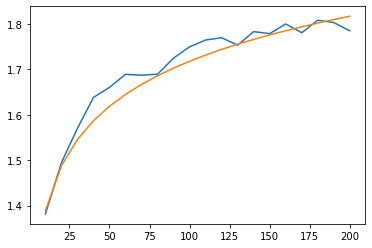

In [151]:
# Plot
X_axis = np.array([i for i in range(10,210,10)])
plt.plot(X_axis, fids_avg/10)
plt.plot(X_axis, np.log(X_axis)/7 + 1.06)
